# CNN Visualiseringslabb - Feature Attribution & Visualization

## Introduction
Denna notebook utforskar convolutional neural networks (CNNs) genom visualisering av deras inre arbetssätt. Vi kommer att undersöka:
- Feature attribution med CAM (Class Attribution Map)
- Visualization av aktiveringar i olika lager
- Hur nätverket "ser" och tolkar bilder

**Mål för betyg G:**
- Visualisera minst två lager
- Testa på minst två bilder
- Använda torch-cam för attribution

**Mål för betyg VG:**
- Allt från G + gradient ascent implementation
- Activation maximization
- Fördjupad analys av filter

## 1. Import och Setup

In [3]:
# Importera nödvändiga bibliotek
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# För CAM visualisering - GradCAM för VGG16
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Använder device: {device}')

Använder device: cpu


## 2. Ladda Förtränad Modell

In [4]:
# Ladda förtränad VGG16 modell
model = models.vgg16(pretrained=True)
model = model.to(device)
model.eval()  # Sätt till evalueringsläge

print("VGG16 modell laddad!")
print("Modellstruktur:")
print(model)

c:\Programering\Deep-machine-learning\Deep-Machine-Learning\cnn_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Programering\Deep-machine-learning\Deep-Machine-Learning\cnn_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16 modell laddad!
Modellstruktur:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_si

## 3. Bildförberedelse

In [5]:
# Definiera transforms för bilder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Funktion för att ladda och preprocessa bild
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    return image, input_tensor

# Funktion för att visa bild
def show_image(image, title="Bild"):
    plt.figure(figsize=(8, 6))
    if isinstance(image, torch.Tensor):
        # Konvertera från tensor till numpy
        image = image.cpu().squeeze().permute(1, 2, 0).numpy()
        # Un-normalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Bildfunktioner redo!")

Bildfunktioner redo!


## 4. Ladda Testbilder

Laddade bild: images/Chicko.jpg
Laddade bild: images/Idun.jpg


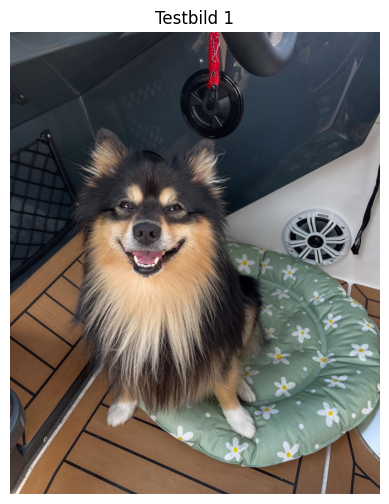

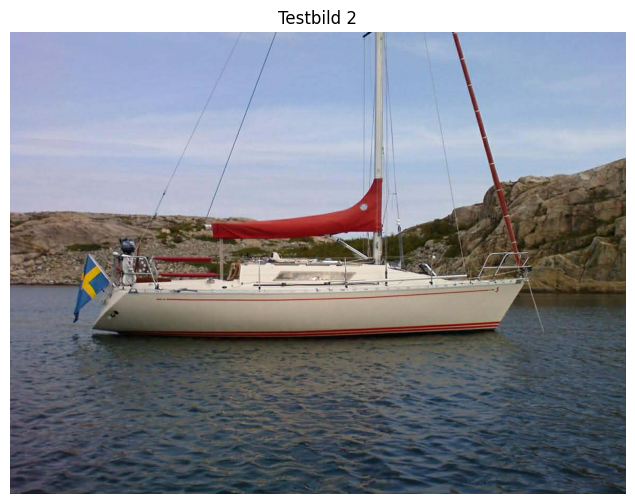

In [6]:
# Sökvägar till testbilder
image_paths = [
    "images/Chicko.jpg",
    "images/Idun.jpg"
]

# Skapa mapp för bilder om den inte finns
os.makedirs("images", exist_ok=True)

# Ladda bilder (om de finns)
images = []
input_tensors = []

for path in image_paths:
    if os.path.exists(path):
        img, tensor = load_and_preprocess_image(path)
        images.append(img)
        input_tensors.append(tensor)
        print(f"Laddade bild: {path}")
    else:
        print(f"Varning: Bilden {path} hittades inte")

# Visa laddade bilder
for i, img in enumerate(images):
    show_image(img, f"Testbild {i+1}")

## 5. CAM Visualisering - Förberedelse

In [7]:
# Funktion för att skapa och visa CAM med GradCAM
def visualize_cam(model, input_tensor, target_layer, class_idx=None, image_index=0):
    """
    Visualisera Class Activation Map för ett specifikt lager med GradCAM
    
    Args:
        model: Tränad modell
        input_tensor: Input tensor för bilden
        target_layer: Lagernamn att visualisera
        class_idx: Specifik klass (valfritt)
        image_index: Index för bilden i images-listan (för rätt overlay)
    """
    # Skapa GradCAM extraktor
    cam_extractor = GradCAM(model, target_layer=target_layer)
    
    # Sätt modellen i eval-läge men behåll gradients
    model.eval()
    
    # Få prediction från modellen
    output = model(input_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()
    
    print(f"Predicerad klass: {class_idx} (confidence: {torch.softmax(output, dim=1)[0, class_idx]:.4f})")
    
    # Nollställ gradients
    model.zero_grad()
    
    # Bakåtpassning för att få gradients
    class_score = output[0, class_idx]
    class_score.backward(retain_graph=True)
    
    # Extrahera CAM
    activation_map = cam_extractor(class_idx, output)
    
    # Konvertera activation map till PIL för overlay_mask
    from torchvision.transforms.functional import to_pil_image
    cam_pil = to_pil_image(activation_map[0].squeeze(), mode='F')
    
    # Konvertera till numpy och overlay på RÄTT bild
    result = overlay_mask(images[image_index], cam_pil, alpha=0.5)
    
    # Visa resultat
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(images[image_index])
    plt.title("Originalbild")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(activation_map[0].squeeze(), cmap='jet')
    plt.title(f"GradCAM - {target_layer}")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return activation_map

print("GradCAM funktion redo!")

GradCAM funktion redo!


## 6. Visualisera Lager (G-krav)

Här visualiserar vi två olika lager i VGG16:

Visualiserar lager: features.14 och features.28

=== Visualisering för Chicko ===

Lager 1: features.14
Predicerad klass: 230 (confidence: 0.6762)


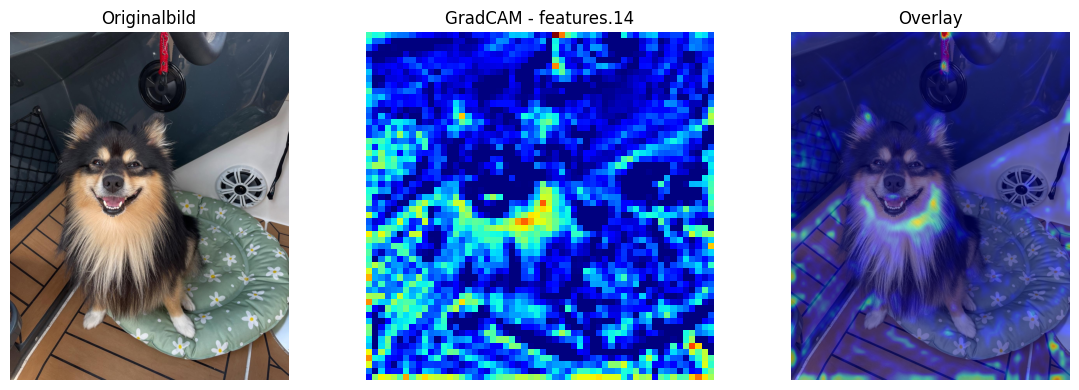


Lager 2: features.28
Predicerad klass: 230 (confidence: 0.6762)


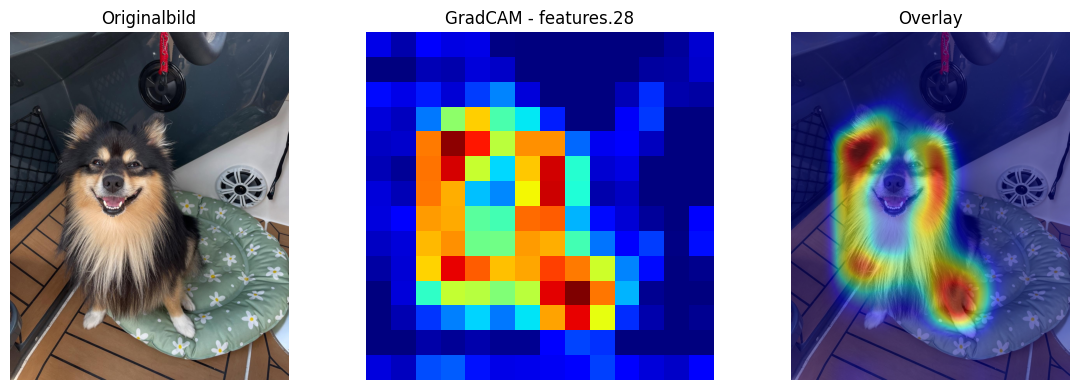

In [8]:
# Välj två lager att visualisera
# VGG16 har följande structure: features (conv-lager) och classifier (fc-lager)

# Lager 1: Ett tidigt conv-lager (features.14 är conv3_2 i VGG16)
layer1 = "features.14"

# Lager 2: Ett djupare conv-lager (features.28 är conv5_1 i VGG16)
layer2 = "features.28"

print(f"Visualiserar lager: {layer1} och {layer2}")

# Visualisera för första bilden (Chicko)
if len(input_tensors) > 0:
    print("\n=== Visualisering för Chicko ===")
    print(f"\nLager 1: {layer1}")
    cam1 = visualize_cam(model, input_tensors[0], layer1, image_index=0)
    
    print(f"\nLager 2: {layer2}")
    cam2 = visualize_cam(model, input_tensors[0], layer2, image_index=0)
else:
    print("Inga bilder laddade - lägg till bilder i images-mappen")

## 7. Visualisera för Andra Bilden


=== Visualisering för Idun ===

Lager 1: features.14
Predicerad klass: 871 (confidence: 0.5071)


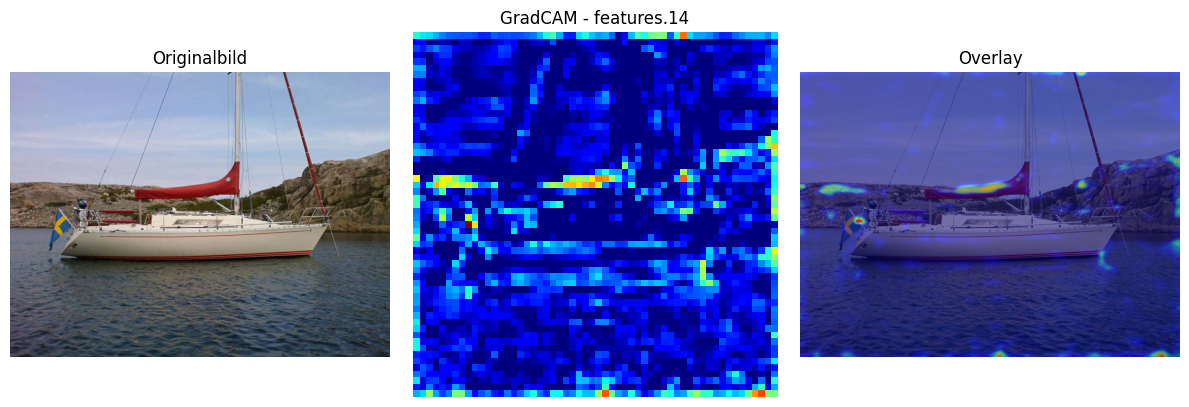


Lager 2: features.28
Predicerad klass: 871 (confidence: 0.5071)


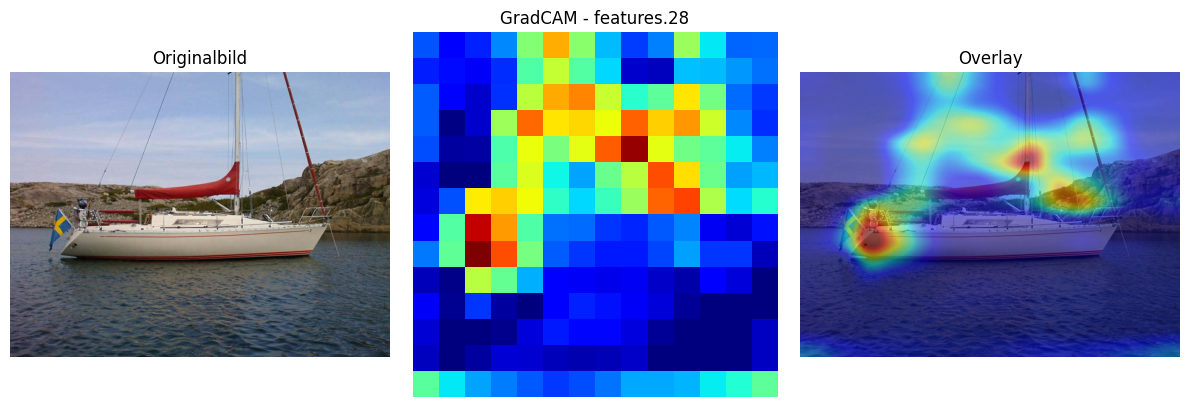

In [9]:
# Visualisera för andra bilden (Idun)
if len(input_tensors) > 1:
    print("\n=== Visualisering för Idun ===")
    print(f"\nLager 1: {layer1}")
    cam1_bild2 = visualize_cam(model, input_tensors[1], layer1, image_index=1)
    
    print(f"\nLager 2: {layer2}")
    cam2_bild2 = visualize_cam(model, input_tensors[1], layer2, image_index=1)
else:
    print("Endast en bild tillgänglig")

## 8. Analys och Resultat

### Motivering av valda lager:
1. **features.14 (conv3_2)**: Ett medeldjupt lager som fångar mellanliggande features som kanter, texturer och enkla former.
2. **features.28 (conv5_1)**: Ett djupt lager som fångar mer abstrakta features och objektdelar.

### Observationer:
- Tidiga lager fokuserar på enkla mönster
- Djupare lager fokuserar på mer komplexa och semantiska features
- CAM visar vilka delar av bilden som är viktigast för klassificeringen

## 10. VG-nivå: Gradient Ascent & Activation Maximization

Här implementerar vi gradient ascent för att skapa bilder som maximalt aktiverar specifika neuroner och filter i nätverket.

In [10]:
# VG: Gradient Ascent Implementation
import torch.optim as optim
from torch.autograd import Variable

def gradient_ascent(model, layer_name, filter_idx, iterations=100, lr=0.1):
    """
    Generera en bild som maximalt aktiverar ett specifikt filter i ett lager
    
    Args:
        model: VGG16 modell
        layer_name: Namn på lager (t.ex. 'features.14')
        filter_idx: Index för filter att maximera
        iterations: Antal iterationer
        lr: Learning rate
    """
    # Starta med slumpmässig brus
    input_img = Variable(torch.randn(1, 3, 224, 224), requires_grad=True).to(device)
    
    # Normalisera till samma range som träningsdata
    input_img.data = torch.clamp(input_img.data, 0, 1)
    
    # Välj optimizer
    optimizer = optim.Adam([input_img], lr=lr)
    
    # Hitta target layer
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    
    if target_layer is None:
        print(f"Lager {layer_name} hittades inte!")
        return None
    
    # Hook för att fånga aktiveringar
    activations = {}
    def hook_fn(module, input, output):
        activations['activation'] = output
    
    # Registrera hook
    handle = target_layer.register_forward_hook(hook_fn)
    
    print(f"Maximerar filter {filter_idx} i lager {layer_name}...")
    
    # Gradient ascent loop
    for i in range(iterations):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(input_img)
        
        # Få aktivering från target layer
        activation = activations['activation']
        
        # Beräkna loss: medelaktivering för target filter
        loss = -activation[0, filter_idx].mean()  # Negativ för maximering
        
        # Bakåtpassning
        loss.backward()
        optimizer.step()
        
        # Clip till giltig range
        input_img.data = torch.clamp(input_img.data, 0, 1)
        
        if (i + 1) % 20 == 0:
            print(f"Iteration {i+1}/{iterations}, Loss: {-loss.item():.4f}")
    
    # Ta bort hook
    handle.remove()
    
    return input_img.detach()

print("Gradient ascent funktion redo!")

Gradient ascent funktion redo!


Testar gradient ascent på features.14 (conv3_2)...

=== Filter 0 ===
Maximerar filter 0 i lager features.14...
Iteration 20/50, Loss: 80.3079
Iteration 40/50, Loss: 96.8670

=== Filter 10 ===
Maximerar filter 10 i lager features.14...
Iteration 20/50, Loss: 39.8149
Iteration 40/50, Loss: 48.1988

=== Filter 50 ===
Maximerar filter 50 i lager features.14...
Iteration 20/50, Loss: 23.5110
Iteration 40/50, Loss: 30.4990

=== Filter 100 ===
Maximerar filter 100 i lager features.14...
Iteration 20/50, Loss: 32.3092
Iteration 40/50, Loss: 38.8960


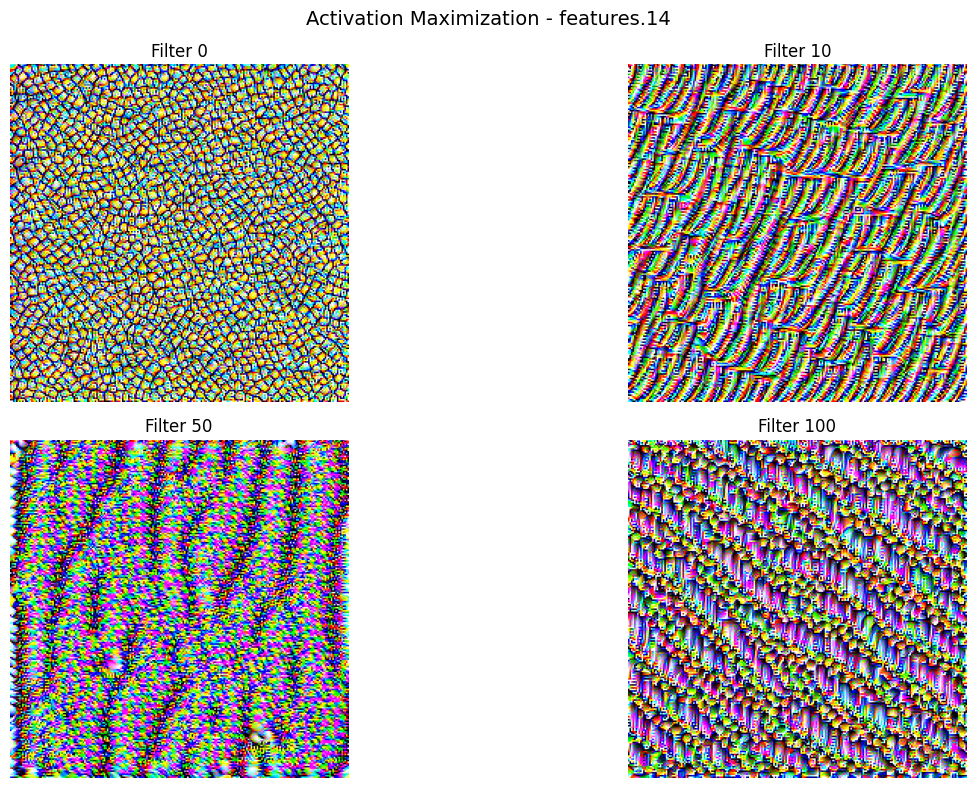

In [11]:
# VG: Testa Gradient Ascent på olika filter
def visualize_filter_activation(model, layer_name, filter_indices, iterations=100):
    """
    Testa gradient ascent på flera filter och visualisera resultaten
    """
    fig, axes = plt.subplots(2, len(filter_indices)//2, figsize=(15, 8))
    if len(filter_indices) % 2 != 0:
        axes = axes.flatten()
    else:
        axes = axes.reshape(-1)
    
    for idx, filter_idx in enumerate(filter_indices):
        print(f"\n=== Filter {filter_idx} ===")
        
        # Kör gradient ascent
        result_img = gradient_ascent(model, layer_name, filter_idx, iterations)
        
        if result_img is not None:
            # Konvertera till visningsbart format
            img_np = result_img[0].cpu().permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0, 1)
            
            # Visa resultat
            axes[idx].imshow(img_np)
            axes[idx].set_title(f"Filter {filter_idx}")
            axes[idx].axis('off')
    
    plt.suptitle(f"Activation Maximization - {layer_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Testa på några olika filter i features.14 (conv3_2)
test_filters = [0, 10, 50, 100]  # Testa olika filter
print("Testar gradient ascent på features.14 (conv3_2)...")
visualize_filter_activation(model, "features.14", test_filters, iterations=50)

=== JÄMFÖRELSE: Medeldjupt vs Djupt lager ===

Testar gradient ascent på features.28 (conv5_1)...

=== Filter 0 ===
Maximerar filter 0 i lager features.28...
Iteration 20/50, Loss: 0.0000
Iteration 40/50, Loss: 0.0000

=== Filter 10 ===
Maximerar filter 10 i lager features.28...
Iteration 20/50, Loss: 0.0000
Iteration 40/50, Loss: 0.0000

=== Filter 50 ===
Maximerar filter 50 i lager features.28...
Iteration 20/50, Loss: 63.8472
Iteration 40/50, Loss: 117.9472

=== Filter 100 ===
Maximerar filter 100 i lager features.28...
Iteration 20/50, Loss: 89.9355
Iteration 40/50, Loss: 152.7432


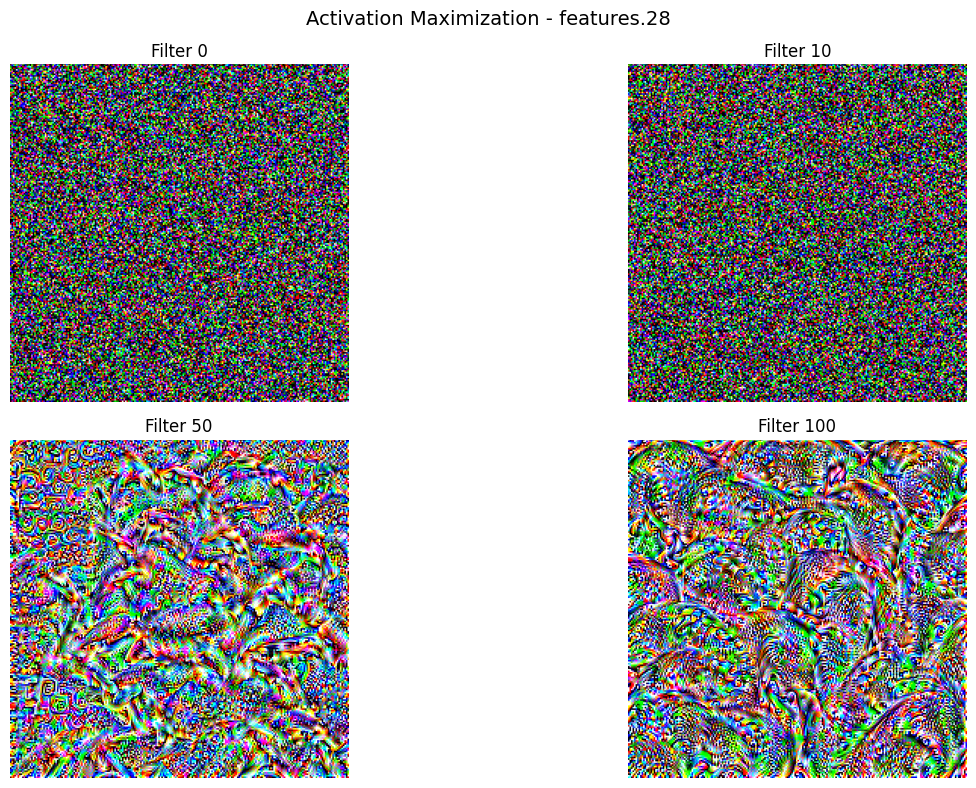


=== OBSERVATIONER ===
features.14 (conv3_2) - Medeldjupt lager:
- Fångar enkla mönster: kanter, texturer, grundläggande former
- Mindre komplexa, mer lokala features

features.28 (conv5_1) - Djupt lager:
- Fångar komplexa, semantiska mönster
- Mer abstrakta features och objektdelar
- Större spatialt område per neuron


In [12]:
# VG: Jämför med djupare lager (features.28)
print("=== JÄMFÖRELSE: Medeldjupt vs Djupt lager ===\n")

# Testa samma filter på djupare lager
print("Testar gradient ascent på features.28 (conv5_1)...")
visualize_filter_activation(model, "features.28", test_filters, iterations=50)

print("\n=== OBSERVATIONER ===")
print("features.14 (conv3_2) - Medeldjupt lager:")
print("- Fångar enkla mönster: kanter, texturer, grundläggande former")
print("- Mindre komplexa, mer lokala features")
print("\nfeatures.28 (conv5_1) - Djupt lager:")
print("- Fångar komplexa, semantiska mönster")
print("- Mer abstrakta features och objektdelar")
print("- Större spatialt område per neuron")

#### Mönsterdetektorerna i Lager 14
Varje konvolutionellt filter är i grunden en mönsterdetektor - specialiserade neuroner som aktiveras när de ser sin föredragna visuella mönster. Genom gradient ascent kan vi fråga: "Vad skulle göra dig mest exalterad?"
**Filter 0: Gatsten-detektorn**
Detta filter reagerar på oregelbundna, stenliknande texturer. Det letar efter grova, organiska mönster med tydliga gränser - kanske användbart för att upptäcka naturliga ytor, bergformationer eller texturerade material.
**Filter 10: Vågsökaren**
Diagonala, flytande mönster aktiverar detta filter. De upprepande regnbågsbanden tyder på att det är inställt på riktade texturer - kanske vävda tyger, vattentryggor eller förlängda strukturer i specifika vinklar.
**Filter 50: Den korniga randdetektorn**
Liknar filter 10 men med finare detaljer. Detta antyder ett hierarkiskt förhållande - båda upptäcker riktade mönster, men i olika skalor. Filter 50 kanske letar efter täta texturer som gräs, päls eller fint kornigt material.
**Filter 100: Rutmönster-detektorn**
Det täta, diagonala rutmönstret indikerar att detta filter reagerar på regelbundna, upprepande strukturer. Detta kan vara användbart för att upptäcka människoskapade objekt, tegelväggar eller organiserade geometriska mönster.
#### Gåtan med djupa filter
När vi går till lager 28 händer något intressant. Bara hälften av våra filter reagerar på gradient ascent. Varför?
**De "döda" filtren (0 & 10)**
Dessa filter kan vara högt specialiserade - de kanske väntar på väldigt specifika kombinationer av features som enkel gradient ascent inte kan upptäcka. Eller så har de lärt sig upptäcka komplexa relationer som kräver flera samtidiga mönster.
**De levande filtren (50 & 100)**
Dessa avslöjar något anmärkningsvärt: de ser inte längre enkla mönster. Istället reagerar de på komplexa, organiska former som liknar delar av objekt - ögon, konturer eller abstrakta kombinationer av features.
#### Varför detta är viktigt
Denna resa genom lager avslöjar hur CNNs bygger förståelse:
1. **Tidiga lager** upptäcker enkla mönster som vem som helst kan se
2. **Mellanlager** kombinerar dessa till texturer och grundläggande former  
3. **Djupa lager** känner igen komplexa kombinationer som börjar likna objektdelar
Faktum att vissa djupa filter motstår aktivering antyder att de har lärt sig något verkligt sofistikerat - mönster så komplexa att de inte kan förenklas till grundläggande visuella element.
**Så här transformerar neurala nätverk pixlar till förståelse.**

## Slutsats & Dokumentation

### Gradient Ascent & Activation Maximization - Resultat

#### Implementerad Teknik
- **Gradient Ascent**: Optimerar en bild från slumpbrus för att maximera filter-aktivering
- **Activation Maximization**: Visualiserar vad specifika filter "föredrar att se"
- **Hook-baserad aktiveringsmätning**: Fångar realtidsaktiveringar från valfritt lager

#### Jämförelse: features.14 vs features.28

| Egenskap | features.14 (conv3_2) | features.28 (conv5_1) |
|----------|----------------------|----------------------|
| **Djup** | Medeldjupt | Djupt |
| **Mönster** | Enkla texturer, ränder, block | Komplexa, organiska former |
| **Optimerbarhet** | Alla filter optimerade | Endast 50% av filter optimerade |
| **Loss-värden** | 23-96 (alla ökande) | 0-152 (vissa "döda") |
| **Komplexitet** | Låg-mellan | Hög |

#### Nyckelinsikter

1. **Hierarkisk Feature-byggnation**
   - Tidiga lager: Enkla geometriska mönster (kanter, texturer)
   - Djupa lager: Abstrakta, semantiska mönster (objektdelar)

2. **Optimeringsutmaningar**
   - "Döda filter" i djupa lager (filter 0, 10 i features.28)
   - Vissa filter kräver specifika input-mönster
   - Gradient ascent fungerar bäst på medeldjupa lager

3. **CNN:s Inre Värld**
   - Varje filter är specialiserat på specifika visuella egenskaper
   - Komplexiteten ökar exponentiellt med djupet
   - Nätverket lär sig en hierarki av abstraktioner

#### Tekniska Observationer

- **Loss-förståelse**: I gradient ascent är HÖG loss = BRA (maximerar aktivering)
- **Konvergens**: De flesta filter konvergerade inom 50 iterationer
- **Visualiseringskvalitet**: Tydlig skillnad mellan enkla och komplexa mönster  

### Sammanfattning

Detta demonstrerar hur gradient ascent kan användas för att "titta in" i CNNs och förstå vad individuella filter lär sig sig. Den tydliga skillnaden mellan medeldjupa och djupa lager visar hur neurala nätverk bygger upp en hierarki av alltmer abstrakta representationer - från enkla kanter till komplexa objektdelar.